In [1]:
import pickle
from pathlib import Path
import jitr
import numpy as np
import rose
from matplotlib import pyplot as plt
import pandas as pd
import chexpy

In [2]:
from rose.koning_delaroche import KDGlobal, Projectile

n = Projectile.neutron
p = Projectile.proton

# initial and final systems
# Core p + Ca48
Ca48 = (48, 20)

# n + IAS
Sc48 = (48, 21)

# lab bombarding energy
E_lab = 25  # MeV

# excitation energy to isobaric analog state
E_IAS = 6.67  # MeV

# approximation of -Q - the Coulomb displacement energy
CDE = 1.33 * (Ca48[1] + Sc48[1]) * 0.5 / Ca48[0] ** (1.0 / 3.0)

# excitation energy to isobaric analog state
Q_IAS = (
    rose.utility.get_AME_binding_energy(*Sc48)
    - rose.utility.get_AME_binding_energy(*Ca48)
    - E_IAS
)
print(f"Q = {Q_IAS}, CDE = {CDE}")

# set up global optical model potentials w/ default KD params
omps = {
    n: rose.koning_delaroche.KDGlobal(n),
    p: rose.koning_delaroche.KDGlobal(p),
}

Q = -7.173131200000098, CDE = 7.502253870092668


In [3]:
xsn = pd.read_csv(
    "./chex_benchmark_results/ca48_25MeV_pn/OutNucleonElasticCS.txt",
    names=["theta", "dxs", "err"],
    sep='\s+',
)

In [4]:
xsp = pd.read_csv(
    "./chex_benchmark_results/ca48_25MeV_pn/InNucleonRatioToRuth.txt",
    names=["theta", "dxs", "err"],
    sep='\s+',
)

In [5]:
# set up meshes for visualization
a = 30
angles = np.array(xsn["theta"], dtype=np.float64) * np.pi / 180

In [6]:
interactions = {}
params = {}

In [24]:
# set up p + Ca48 system
# kinematics for p + Ca48 system
mu_p, E_com_p, k_p, eta_p = rose.utility.kinematics(
    target=Ca48, projectile=(1, 1), E_lab=E_lab
)

# get default OMP params for p + Ca48 system
R_C, parameters = omps[p].get_params(*Ca48, mu_p, E_lab, k_p)

params[p] = (R_C, parameters)

# set up interaction space for p + Ca48 system
interactions[p] = rose.InteractionSpace(
    coordinate_space_potential=rose.koning_delaroche.KD_simple,
    n_theta=rose.koning_delaroche.NUM_PARAMS,
    mu=mu_p,
    energy=E_com_p,
    is_complex=True,
    spin_orbit_term=rose.koning_delaroche.KD_simple_so,
    Z_1=1,
    Z_2=Ca48[1],
    R_C=R_C,
    l_max=50,
)

In [25]:
# set up n + Sc48 system
# kinematics for n + Sc48 system
E_com_n = E_com_p + Q_IAS
mu_n, E_lab_n, k_n, eta_n = rose.utility.kinematics(
    target=Sc48, projectile=(1, 0), E_com=E_com_n
)

# get default OMP params for n + Sc48 system
_, parameters = omps[n].get_params(*Sc48, mu_n, E_lab_n, k_n)
params[n] = (R_C, parameters)

# set up interaction space for n + Sc48 system
interactions[n] = rose.InteractionSpace(
    coordinate_space_potential=rose.koning_delaroche.KD_simple,
    n_theta=rose.koning_delaroche.NUM_PARAMS,
    mu=mu_n,
    energy=E_com_n,
    is_complex=True,
    spin_orbit_term=rose.koning_delaroche.KD_simple_so,
    Z_1=0,
    Z_2=Sc48[1],
    l_max=50,
)

In [26]:
s_0_p = a * k_p
s_0_n = a *  k_n
min_s = 1e-1
s_mesh_p = np.linspace(min_s, s_0_p, 1000)
domain_p = [min_s, s_0_p]
s_mesh_n = np.linspace(min_s, s_0_n, 1000)
domain_n = [min_s, s_0_n]

In [27]:
solver = jitr.RMatrixSolver(50)

In [28]:
# set up solvers
N = 100
solvers = {}

solvers[n] = rose.ScatteringAmplitudeEmulator.HIFI_solver(
    interactions[n],
    base_solver=rose.LagrangeRmatrix(
        interactions[n].interactions[0][0],
        s_0_n,
        solver,
    ),
    angles=angles,
    s_mesh=s_mesh_n,
)

solvers[p] = rose.ScatteringAmplitudeEmulator.HIFI_solver(
    interactions[p],
    base_solver=rose.LagrangeRmatrix(
        interactions[p].interactions[0][0],
        s_0_p,
        solver,
    ),
    angles=angles,
    s_mesh=s_mesh_p,
)

Let's compare the value of the isovector component of the optical potential the `JITR` solver and the original `CHEX` solver, for a single partial wave.

In [29]:
params[p][1]

array([50.96318785,  4.33328708,  0.6706624 ,  2.29860499,  4.33328708,
        0.6706624 ,  8.13772168,  4.66926318,  0.543684  ,  5.32128688,
        3.6610295 ,  0.59      , -0.12462904,  3.6610295 ,  0.59      ])

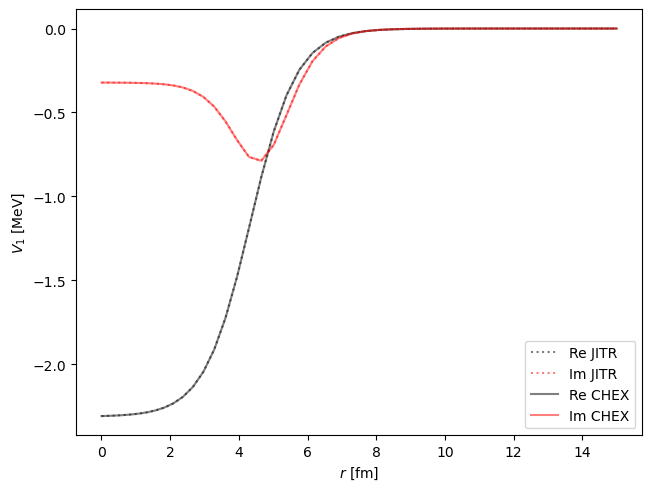

In [30]:
import pandas as pd

chex_v1 = pd.read_csv(
    "./chex_benchmark_results/ca48_25MeV_pn/KD_pot.txt",
    names=["r", "V", "W"],
    sep='\s+',
)

# CHEX uses Ecm to evaluate V1, not Elab. Elab is used for distorted waves
# CHEX also includes the full Coulomb potential in V1

# to do apples to apples, lets get new params with Ecm and calculate V1 in the same way as CHEX
_, alphan = omps[n].get_params(*Sc48, mu_n, E_com_n, k_n)
RC, alphap = omps[p].get_params(*Ca48, mu_p, E_com_p, k_p)

def jitr_v1(r, li, ji, alphan, alphap, chex_way=True):
    A,Z = Ca48
    N = A-Z
    vn = (
        interactions[n].interactions[li][ji].v_r(r, alphan) 
      + interactions[n].interactions[li][ji].spin_orbit_term.spin_orbit_potential(r, alphan)
    )
    vp = (
        interactions[p].interactions[li][ji].v_r(r, alphap) 
      + interactions[p].interactions[li][ji].spin_orbit_term.spin_orbit_potential(r, alphap)
    )
    if chex_way:
        v1 =  -(vn - vp) * np.sqrt(np.fabs(N-Z))/(N-Z-1) # the CHEX way
    else:
        v1 =  -(vn - vp) / np.sqrt(np.abs(N-Z)) # the correct way
    return v1
    
r = np.array(chex_v1["r"])
jitrv1 = jitr_v1(r,0,0, alphan, alphap, chex_way=True)
plt.plot(r, jitrv1.real, ":k", label="Re JITR", alpha=0.5)
plt.plot(r, jitrv1.imag, ":r", label="Im JITR", alpha=0.5)

plt.plot(chex_v1["r"], chex_v1["V"], "k", label="Re CHEX", alpha=0.5)
plt.plot(chex_v1["r"], chex_v1["W"], "r", label="Im CHEX", alpha=0.5)

plt.legend()
plt.tight_layout()
plt.xlabel(r"$r$ [fm]")
plt.ylabel(r"$V_1$ [MeV]")
plt.show()

Let's compare phase shifts and partial waves between the `JITR` solver and the original `CHEX` solver, for a single partial wave.

Let's compare the elastic cross sections for the entrance and exit channels between the `JITR` solver and the original `CHEX` solver, for a single partial wave.

First, for comparison, let's duplicate the same solvers and interactions, but using the same reduced mass as CHEX, which is just calculated like $A/(A+1)m_n$. This will tell us about how important our relativistic correction is.

In [23]:
R_C

0

In [35]:
interactions_kip = rose.InteractionSpace(
    coordinate_space_potential=rose.koning_delaroche.KD_simple,
    n_theta=rose.koning_delaroche.NUM_PARAMS,
    mu=912.48391836734697,
    energy=E_com_p,
    is_complex=True,
    spin_orbit_term=rose.koning_delaroche.KD_simple_so,
    Z_1=1,
    Z_2=Ca48[1],
    R_C=R_C,
    l_max=50,
)
solvers_kip = rose.ScatteringAmplitudeEmulator.HIFI_solver(
    interactions_kip,
    base_solver=rose.LagrangeRmatrix(
        interactions_kip.interactions[0][0],
        s_0_p,
        solver,
    ),
    angles=angles,
    s_mesh=s_mesh_p,
)
dxs_kip = solvers_kip.exact_dsdo(params[p][1])

In [36]:
# for the proton case, our original solver with good kineamatics
dxs = solvers[p].exact_dsdo(params[p][1])

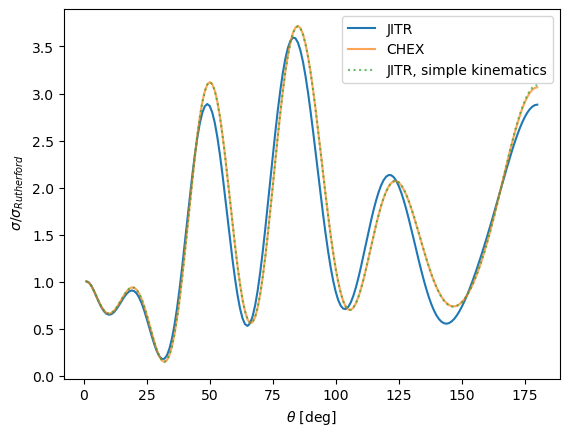

In [40]:
plt.plot(angles * 180 / np.pi, dxs, label="JITR")
plt.plot(xsp["theta"], xsp["dxs"], label="CHEX",alpha=0.7, )
plt.plot(angles * 180 / np.pi, dxs_kip, ":", alpha=0.7, label="JITR, simple kinematics")

plt.xlabel(r"$\theta$ [deg]")
plt.ylabel(r" $\sigma / \sigma_{Rutherford}$")
plt.legend()

In [17]:
#%%timeit
# now for the neutron case
dxs = solvers[n].exact_dsdo(params[n][1])

In [18]:
# use same kinematics as chex
interactions_chex_match_kin = rose.InteractionSpace(
    coordinate_space_potential=rose.koning_delaroche.KD_simple,
    n_theta=rose.koning_delaroche.NUM_PARAMS,
    mu=912.48391836734697,
    energy=E_com_n,
    is_complex=True,
    spin_orbit_term=rose.koning_delaroche.KD_simple_so,
    Z_1=0,
    Z_2=Sc48[1],
    l_max=50,
)
solver_chex_match_kin = rose.ScatteringAmplitudeEmulator.HIFI_solver(
    interactions_chex_match_kin,
    base_solver=rose.LagrangeRmatrix(
        interactions_chex_match_kin.interactions[0][0],
        s_0_n,
        solver,
    ),
    angles=angles,
    s_mesh=s_mesh_n,
)
dxs_kin = solver_chex_match_kin.exact_dsdo(params[n][1])

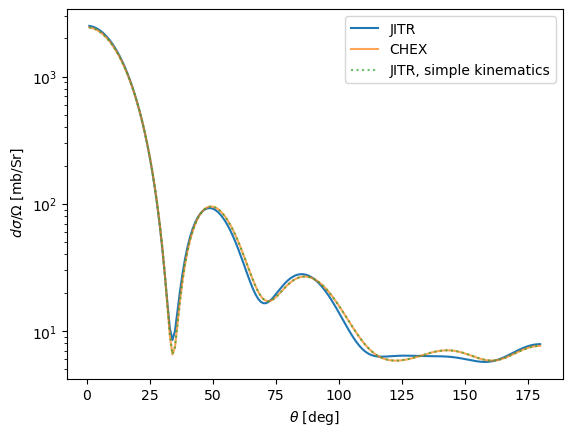

In [21]:
plt.semilogy(angles * 180 / np.pi, dxs, label="JITR")

plt.semilogy(xsn["theta"], xsn["dxs"], label="CHEX",alpha=0.7)
plt.semilogy(angles * 180 / np.pi, dxs_kin, ":", label="JITR, simple kinematics", alpha=0.7)

plt.xlabel(r"$\theta$ [deg]")
plt.ylabel(r" $d \sigma / \Omega$ [mb/Sr]")
plt.legend()

In [ ]:
48*1/(48 +1 ) * 931.4940

In [ ]:
k_n, mu_n, E_com_n, E_lab_n

In [ ]:
jitr.H_plus(27.026897497893970,0,0)

In [ ]:
solvers[n].rbes[0][0].basis.solver.s_0

In [ ]:
jitr.H_plus(solvers[n].rbes[0][0].basis.solver.s_0,0,0)

In [ ]:
solvers[n].rbes[0][0].basis.solver.channels[["Hp", "Hm", "Hpp", "Hmp"]]

In [ ]:
rm = solvers[n].exact_rmatrix_elements(params[n][1])
rm

In [ ]:
ch, im = solvers[p].rbes[0][0].basis.solver.get_channel_info(params[p][1])
R, S, x, uext_prime_boundary = solvers[p].rbes[0][0].basis.solver.solver.solve(im, ch, wavefunction=True)

In [ ]:
def partial_wave_tdwba(i,j,N,Z,params_n, params_p):
    abscissa = solvers[p].rbes[i][j].basis.solver.solver.kernel.quadrature.abscissa
    ch, im = solvers[p].rbes[i][j].basis.solver.get_channel_info(params_p)
    R, S, xp, uext_prime_boundary = solvers[n].rbes[i][j].basis.solver.solver.solve(im, ch, wavefunction=True)

    ch, im = solvers[n].rbes[i][j].basis.solver.get_channel_info(params_n)
    R, S, xn, uext_prime_boundary = solvers[n].rbes[i][j].basis.solver.solver.solve(im, ch, wavefunction=True)
    r  = abscissa * (ch[0]["a"] / ch[0]["k"])
    vn = (
        interactions[n].interactions[i][j].v_r(r, params_n) 
      + interactions[n].interactions[i][j].spin_orbit_term.spin_orbit_potential(r, params_n)
    )
    vp = (
        interactions[p].interactions[i][j].v_r(r, params_p) 
      + interactions[p].interactions[i][j].spin_orbit_term.spin_orbit_potential(r, params_p)
    )
    v1 =  -(vn - vp) / np.sqrt(np.abs(N-Z)) 

    return np.sum(xn.conj() * v1 * xp)